In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data as td
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

torch.manual_seed(0)
data_path = 'content'
version = 4

In [2]:
df = pd.read_csv(f'{data_path}/data.csv')

In [ ]:
target = 'Air Quality'
features = ['CO', 'NO2', 'Population_Density', 'Proximity_to_Industrial_Areas', 'Temperature']

df = df[features + [target]]
df.head()

,CO,NO2,Population_Density,Proximity_to_Industrial_Areas,Temperature,Air Quality
0,1.72,18.9,319,6.3,29.8,Moderate
1,1.64,30.8,611,6.0,28.3,Moderate
2,1.63,24.4,619,5.2,23.1,Moderate
3,1.15,13.5,551,11.1,27.1,Good
4,1.01,21.9,303,12.7,26.5,Good


In [4]:
max_values = df.drop(columns=[target]).max()  
df.iloc[:, :-1] = df.iloc[:, :-1] / max_values

/var/folders/10/vcvbnp396238kmcwww0pldcc0000gn/T/ipykernel_751/2767821176.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0.333333
1       0.638454
2       0.646813
3       0.575758
4       0.316614
          ...   
4995    0.799373
4996    0.740857
4997    0.396029
4998    0.251829
4999    0.481714
Name: Population_Density, Length: 5000, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, :-1] = df.iloc[:, :-1] / max_values


In [5]:
# make target one-hot
df = pd.get_dummies(df, columns=[target], prefix='', prefix_sep='')
df.head(200)

,CO,NO2,Population_Density,Proximity_to_Industrial_Areas,Temperature,Good,Hazardous,Moderate,Poor
0,0.462366,0.291217,0.333333,0.244186,0.508532,False,False,True,False
1,0.440860,0.474576,0.638454,0.232558,0.482935,False,False,True,False
2,0.438172,0.375963,0.646813,0.201550,0.394198,False,False,True,False
3,0.309140,0.208012,0.575758,0.430233,0.462457,True,False,False,False
4,0.271505,0.337442,0.316614,0.492248,0.452218,True,False,False,False
...,...,...,...,...,...,...,...,...,...
195,0.325269,0.419106,0.536050,0.290698,0.554608,False,False,True,False
196,0.268817,0.231125,0.384535,0.434109,0.418089,True,False,False,False
197,0.392473,0.451464,0.657262,0.457364,0.498294,False,False,True,False
198,0.532258,0.476117,0.646813,0.135659,0.617747,False,True,False,False


In [19]:
df[df['Hazardous'] == True]

,CO,NO2,Population_Density,Proximity_to_Industrial_Areas,Temperature,Good,Hazardous,Moderate,Poor
5,0.489247,0.661017,0.704284,0.120155,0.672355,False,True,False,False
29,0.620968,0.486903,0.820272,0.112403,0.895904,False,True,False,False
30,0.478495,0.432974,0.587252,0.135659,0.762799,False,True,False,False
39,0.569892,0.624037,0.639498,0.189922,0.568259,False,True,False,False
40,0.701613,0.608629,0.938349,0.096899,0.639932,False,True,False,False
...,...,...,...,...,...,...,...,...,...
4981,0.752688,0.462250,0.571578,0.302326,0.708191,False,True,False,False
4986,0.548387,0.489985,0.791014,0.806202,0.607509,False,True,False,False
4989,0.481183,0.855162,0.806688,0.116279,0.757679,False,True,False,False
4990,0.879032,0.520801,0.615465,0.143411,0.798635,False,True,False,False


In [6]:
target = ['Good', 'Hazardous', 'Moderate', 'Poor']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df[features].values,
                                                    df[target].values,
                                                    test_size=0.20,
                                                    random_state=0,
                                                    stratify=df[target])

x_train


array([[0.23387097, 0.29738059, 0.48484848, 0.48449612, 0.51877133],
       [0.39784946, 0.33127889, 0.40020899, 0.32170543, 0.5221843 ],
       [0.33064516, 0.3990755 , 0.56321839, 0.23255814, 0.46757679],
       ...,
       [0.26344086, 0.28197227, 0.27481714, 0.49224806, 0.51023891],
       [0.66666667, 0.59938367, 0.553814  , 0.15503876, 0.75085324],
       [0.27419355, 0.2835131 , 0.24555904, 0.40310078, 0.47098976]],
      shape=(4000, 5))

In [ ]:
class AirQualityNet(torch.nn.Module):
    def __init__(self):
        super(AirQualityNet, self).__init__()
        self.fc1 = torch.nn.Linear(5, 10)
        self.fc2 = torch.nn.Linear(10, 10)
        self.fc3 = torch.nn.Linear(10, 10)
        self.fc4 = torch.nn.Linear(10, 4)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        return torch.sigmoid(x) > 0.5

In [ ]:
def train(model, data_loader, optimizer, loss_criteria):
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, _target = tensor
        optimizer.zero_grad()
        
        out = model(data)
        loss = loss_criteria(out, _target) 
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = train_loss / (batch + 1)
    print(f'Training set: Average loss: {avg_loss:.6f}')
    return avg_loss

def test(model, data_loader, loss_criteria):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0 

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, _target = tensor
            
            out = model(data)
            test_loss += loss_criteria(out, _target).item()

            predicted = model.predict(data)  
            correct += (predicted == _target).sum().item()
            total += _target.numel()  

    avg_loss = test_loss / batch_count
    accuracy = 100. * correct / total  

    print(f'Validation set: Average loss: {avg_loss:.6f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)\n')
    return avg_loss

In [9]:
train_x = torch.tensor(x_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)

# Create dataset and dataloader
train_ds = td.TensorDataset(train_x, train_y)
train_loader = td.DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=1)

# Convert x_test and y_test to tensors
test_x = torch.tensor(x_test, dtype=torch.float32)
test_y = torch.tensor(y_test, dtype=torch.float32)

# Create dataset and dataloader
test_ds = td.TensorDataset(test_x, test_y)
test_loader = td.DataLoader(test_ds, batch_size=10, shuffle=False, num_workers=1)

In [78]:
model = AirQualityNet()
model

AirQualityNet(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=4, bias=True)
)

In [79]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Use BCEWithLogitsLoss for binary classification
loss_criteria = nn.BCEWithLogitsLoss()

epochs = 20
for epoch in range(1, epochs + 1):
    print(f'Epoch: {epoch}')
    train_loss = train(model, train_loader, optimizer, loss_criteria)
    test_loss = test(model, test_loader, loss_criteria)

Epoch: 1
Training set: Average loss: 0.584366
Validation set: Average loss: 0.530204, Accuracy: 3000/4000 (75.00%)

Epoch: 2
Training set: Average loss: 0.464628
Validation set: Average loss: 0.344420, Accuracy: 3359/4000 (83.97%)

Epoch: 3
Training set: Average loss: 0.299062
Validation set: Average loss: 0.264665, Accuracy: 3413/4000 (85.33%)

Epoch: 4
Training set: Average loss: 0.240918
Validation set: Average loss: 0.217337, Accuracy: 3610/4000 (90.25%)

Epoch: 5
Training set: Average loss: 0.203770
Validation set: Average loss: 0.189079, Accuracy: 3674/4000 (91.85%)

Epoch: 6
Training set: Average loss: 0.182447
Validation set: Average loss: 0.170251, Accuracy: 3649/4000 (91.22%)

Epoch: 7
Training set: Average loss: 0.168999
Validation set: Average loss: 0.158222, Accuracy: 3718/4000 (92.95%)

Epoch: 8
Training set: Average loss: 0.159493
Validation set: Average loss: 0.148676, Accuracy: 3793/4000 (94.83%)

Epoch: 9
Training set: Average loss: 0.152057
Validation set: Average lo

In [ ]:
acc = 96
version = 3
model_file = f'air_quality_v{version}_acc_{acc}.pt'
torch.save(model.state_dict(), model_file)
del model

In [10]:
acc = 96
version = 3
model_file = f'air_quality_v{version}_acc_{acc}.pt'
model = AirQualityNet()
model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [ ]:
model.eval()

def predict_single(model, input_data):
    input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0)
    
    with torch.no_grad():
        prediction = model.predict(input_data) 
    
    predicted_classes = [target[i] for i in range(len(prediction[0])) if prediction[0][i]]
    
    return predicted_classes

new_data = [0.30376344, 0.41140216, 0.2476489 , 0.47674419, 0.39761092] 
predicted_classes = predict_single(model, new_data)

print(f'Predicted Air Quality: {predicted_classes}')


Predicted Air Quality: ['Good']


In [83]:
X, y = train_test_split(df[features + target], test_size=0.20, random_state=0, stratify=df[target])
[y[features].values, y[target].values]

#test for the first 10 samples
for i in range(len(y)):
    actual_class = [target[j] for j in range(len(y[target].values[i])) if y[target].values[i][j]]
    if actual_class[0] == 'Poor':
        new_data = y[features].values[i]
        predicted_class = predict_single(model, new_data)
        print(f'Predicted Air Quality: {predicted_class}, Actual Air Quality: {actual_class[0]}')

Predicted Air Quality: ['Hazardous'], Actual Air Quality: Poor
Predicted Air Quality: ['Poor'], Actual Air Quality: Poor
Predicted Air Quality: ['Poor'], Actual Air Quality: Poor
Predicted Air Quality: ['Poor'], Actual Air Quality: Poor
Predicted Air Quality: ['Poor'], Actual Air Quality: Poor
Predicted Air Quality: ['Moderate'], Actual Air Quality: Poor
Predicted Air Quality: ['Poor'], Actual Air Quality: Poor
Predicted Air Quality: ['Poor'], Actual Air Quality: Poor
Predicted Air Quality: ['Poor'], Actual Air Quality: Poor
Predicted Air Quality: ['Poor'], Actual Air Quality: Poor
Predicted Air Quality: ['Hazardous'], Actual Air Quality: Poor
Predicted Air Quality: ['Hazardous'], Actual Air Quality: Poor
Predicted Air Quality: ['Poor'], Actual Air Quality: Poor
Predicted Air Quality: ['Poor'], Actual Air Quality: Poor
Predicted Air Quality: ['Poor'], Actual Air Quality: Poor
Predicted Air Quality: ['Moderate'], Actual Air Quality: Poor
Predicted Air Quality: ['Poor'], Actual Air Quali

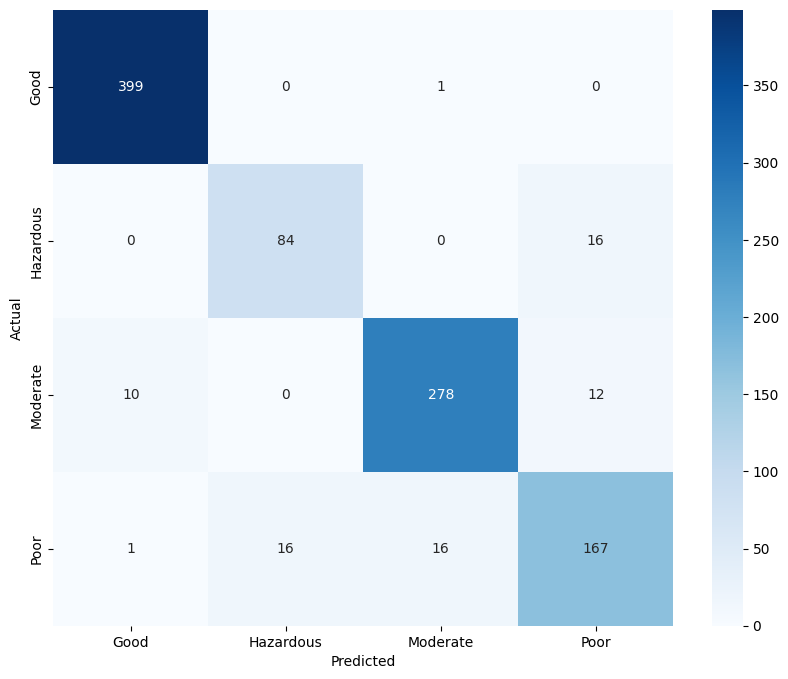

In [11]:
# Confusion matrix with heatmap
y_pred = model.predict(test_x)
y_pred = y_pred.numpy().astype(int)
y_true = test_y.numpy().astype(int)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target, yticklabels=target)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=target))

              precision    recall  f1-score   support

        Good       0.99      0.99      0.99       400
   Hazardous       0.84      0.84      0.84       100
    Moderate       0.94      0.93      0.93       300
        Poor       0.84      0.84      0.84       200

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.93      0.93      0.93      1000
 samples avg       0.93      0.93      0.93      1000



/Users/kazimashry/Documents/DNN_learn/MS_DNN_Practice/DNN_kaggle_air_quality/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

def compute_accuracy(model, test_x, test_y):
    model.eval()
    
    test_x = torch.tensor(test_x, dtype=torch.float32)
    test_y = torch.tensor(test_y, dtype=torch.float32)

    with torch.no_grad():
        predictions = model.predict(test_x)

    correct_predictions = (predictions == test_y).sum().item()

    accuracy = correct_predictions / (len(test_y) * len(test_y[0]))
    
    print(f'Overall accuracy: {accuracy * 100:.2f}%')
    return accuracy

accuracy = compute_accuracy(model, test_x, test_y)


Overall accuracy: 96.50%


/var/folders/10/vcvbnp396238kmcwww0pldcc0000gn/T/ipykernel_3000/2552956653.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_x = torch.tensor(test_x, dtype=torch.float32)
/var/folders/10/vcvbnp396238kmcwww0pldcc0000gn/T/ipykernel_3000/2552956653.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y = torch.tensor(test_y, dtype=torch.float32)
